In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [28]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [29]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=50000 # length of data set
P=500 # range to fit acf

In [30]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

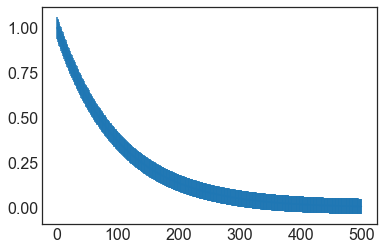

In [31]:
plt.errorbar(t,acf_mean,yerr=acf_std)

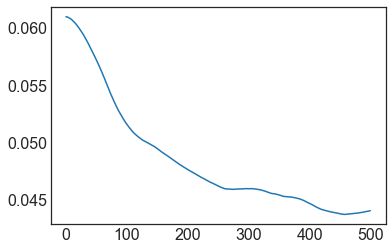

In [32]:
plt.plot(t,acf_std)

In [33]:
acf_all[0].size

500

In [34]:
mod = ExponentialModel()
result_array = None
for i,y in enumerate(acf_all):
    print("***** Iteration ",i," *****")
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = None
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            out.covar[0,0],
                            out.values['amplitude'],
                            out.covar[1,1],
                            out.covar[0,1]])
        print(out.fit_report(min_correl=0.25))
        

    if result_array is None:
        result_array = fit_results
    else:
        result_array = np.vstack((result_array, fit_results))


***** Iteration  0  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 0.84850508
    reduced chi-square = 0.00170383
    Akaike info crit   = -3185.44365
    Bayesian info crit = -3177.01444
[[Variables]]
    decay:      97.9347835 +/- 1.10194975 (1.13%) (init = 100)
    amplitude:  1.04521696 +/- 0.00826403 (0.79%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

***** Iteration  1  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.11800278
    reduced chi-square = 2.3695e-04
    Akaike info crit   = -4171.82758
    Bayesian info crit = -4163.39836
[[Variables]]
    decay:      107.093024 +/- 0.44517477 (0.42%) (init = 100)
    amplitude:

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.08957321
    reduced chi-square = 1.7987e-04
    Akaike info crit   = -4309.65356
    Bayesian info crit = -4301.22434
[[Variables]]
    decay:      121.744796 +/- 0.39991771 (0.33%) (init = 100)
    amplitude:  1.05211499 +/- 0.00241986 (0.23%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.707

***** Iteration  62  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.06276101
    reduced chi-square = 1.2603e-04
    Akaike info crit   = -4487.51466
    Bayesian info crit = -4479.08545
[[Variables]]
    decay:      112.422326 +/- 0.32841998 (0.29%) (init = 100)
    amplitude:  1.02623365 +/- 0.002103

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.33526209
    reduced chi-square = 6.7322e-04
    Akaike info crit   = -3649.72540
    Bayesian info crit = -3641.29619
[[Variables]]
    decay:      92.6405716 +/- 0.66803893 (0.72%) (init = 100)
    amplitude:  1.05297110 +/- 0.00533640 (0.51%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

***** Iteration  116  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.26349149
    reduced chi-square = 5.2910e-04
    Akaike info crit   = -3770.17115
    Bayesian info crit = -3761.74193
[[Variables]]
    decay:      83.8923409 +/- 0.56362367 (0.67%) (init = 100)
    amplitude:  1.05151000 +/- 0.00496

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.13632007
    reduced chi-square = 2.7374e-04
    Akaike info crit   = -4099.67891
    Bayesian info crit = -4091.24969
[[Variables]]
    decay:      88.2570435 +/- 0.44980856 (0.51%) (init = 100)
    amplitude:  0.97263213 +/- 0.00348383 (0.36%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

***** Iteration  184  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.04273779
    reduced chi-square = 8.5819e-05
    Akaike info crit   = -4679.63992
    Bayesian info crit = -4671.21070
[[Variables]]
    decay:      93.1509527 +/- 0.28024428 (0.30%) (init = 100)
    amplitude:  0.89872204 +/- 0.00190


***** Iteration  251  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 0.07874991
    reduced chi-square = 1.5813e-04
    Akaike info crit   = -4374.04313
    Bayesian info crit = -4365.61391
[[Variables]]
    decay:      94.6071314 +/- 0.34465634 (0.36%) (init = 100)
    amplitude:  0.99996031 +/- 0.00256010 (0.26%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

***** Iteration  252  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.03560315
    reduced chi-square = 7.1492e-05
    Akaike info crit   = -4770.96470
    Bayesian info crit = -4762.53548
[[Variables]]
    decay:      125.425766 +/- 0.26243298 (0.21%) (init = 100)
    ampli

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.49557546
    reduced chi-square = 9.9513e-04
    Akaike info crit   = -3454.32187
    Bayesian info crit = -3445.89265
[[Variables]]
    decay:      103.334312 +/- 1.00787389 (0.98%) (init = 100)
    amplitude:  0.89822132 +/- 0.00615434 (0.69%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

***** Iteration  318  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.12542716
    reduced chi-square = 2.5186e-04
    Akaike info crit   = -4141.31908
    Bayesian info crit = -4132.88987
[[Variables]]
    decay:      96.6230821 +/- 0.51926131 (0.54%) (init = 100)
    amplitude:  0.84683823 +/- 0.00319

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.11345471
    reduced chi-square = 2.2782e-04
    Akaike info crit   = -4191.47983
    Bayesian info crit = -4183.05061
[[Variables]]
    decay:      117.831594 +/- 0.43426564 (0.37%) (init = 100)
    amplitude:  1.07072034 +/- 0.00276567 (0.26%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.706

***** Iteration  388  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.30411164
    reduced chi-square = 6.1067e-04
    Akaike info crit   = -3698.48426
    Bayesian info crit = -3690.05504
[[Variables]]
    decay:      82.1418915 +/- 0.61099974 (0.74%) (init = 100)
    amplitude:  1.03089493 +/- 0.00538

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.06374186
    reduced chi-square = 1.2800e-04
    Akaike info crit   = -4479.76093
    Bayesian info crit = -4471.33171
[[Variables]]
    decay:      113.764672 +/- 0.35160814 (0.31%) (init = 100)
    amplitude:  0.97225839 +/- 0.00210785 (0.22%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.706

***** Iteration  460  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.57370975
    reduced chi-square = 0.00115203
    Akaike info crit   = -3381.11989
    Bayesian info crit = -3372.69067
[[Variables]]
    decay:      83.7906652 +/- 0.95079892 (1.13%) (init = 100)
    amplitude:  0.91925210 +/- 0.00732

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.03875430
    reduced chi-square = 7.7820e-05
    Akaike info crit   = -4728.56087
    Bayesian info crit = -4720.13166
[[Variables]]
    decay:      111.086088 +/- 0.25314500 (0.23%) (init = 100)
    amplitude:  1.03946650 +/- 0.00166232 (0.16%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

***** Iteration  531  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.39812833
    reduced chi-square = 7.9945e-04
    Akaike info crit   = -3563.79450
    Bayesian info crit = -3555.36528
[[Variables]]
    decay:      82.2564626 +/- 0.71263194 (0.87%) (init = 100)
    amplitude:  1.01204989 +/- 0.00616

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.08805639
    reduced chi-square = 1.7682e-04
    Akaike info crit   = -4318.19298
    Bayesian info crit = -4309.76377
[[Variables]]
    decay:      96.1610001 +/- 0.32494491 (0.34%) (init = 100)
    amplitude:  1.13102037 +/- 0.00268591 (0.24%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

***** Iteration  600  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.24958837
    reduced chi-square = 5.0118e-04
    Akaike info crit   = -3797.27517
    Bayesian info crit = -3788.84595
[[Variables]]
    decay:      107.105339 +/- 0.67375452 (0.63%) (init = 100)
    amplitude:  0.97189573 +/- 0.00429

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.06858591
    reduced chi-square = 1.3772e-04
    Akaike info crit   = -4443.13816
    Bayesian info crit = -4434.70894
[[Variables]]
    decay:      111.373131 +/- 0.32327893 (0.29%) (init = 100)
    amplitude:  1.08433885 +/- 0.00220870 (0.20%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

***** Iteration  667  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.23417558
    reduced chi-square = 4.7023e-04
    Akaike info crit   = -3829.14611
    Bayesian info crit = -3820.71689
[[Variables]]
    decay:      84.8716385 +/- 0.58995686 (0.70%) (init = 100)
    amplitude:  0.95268812 +/- 0.00465

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.26966362
    reduced chi-square = 5.4149e-04
    Akaike info crit   = -3758.59402
    Bayesian info crit = -3750.16480
[[Variables]]
    decay:      90.4998418 +/- 0.70138325 (0.78%) (init = 100)
    amplitude:  0.88867796 +/- 0.00484058 (0.54%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

***** Iteration  733  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.17827491
    reduced chi-square = 3.5798e-04
    Akaike info crit   = -3965.51830
    Bayesian info crit = -3957.08909
[[Variables]]
    decay:      114.284357 +/- 0.57903516 (0.51%) (init = 100)
    amplitude:  0.98981381 +/- 0.00351

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.05391358
    reduced chi-square = 1.0826e-04
    Akaike info crit   = -4563.49045
    Bayesian info crit = -4555.06124
[[Variables]]
    decay:      106.262513 +/- 0.32383943 (0.30%) (init = 100)
    amplitude:  0.93584415 +/- 0.00200278 (0.21%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

***** Iteration  798  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 0.59912642
    reduced chi-square = 0.00120307
    Akaike info crit   = -3359.44537
    Bayesian info crit = -3351.01616
[[Variables]]
    decay:      90.3772793 +/- 0.87093228 (0.96%) (init = 100)
    amplitude:  1.06608187 +/- 0.00721

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.09571975
    reduced chi-square = 1.9221e-04
    Akaike info crit   = -4276.46936
    Bayesian info crit = -4268.04015
[[Variables]]
    decay:      97.0474653 +/- 0.43128615 (0.44%) (init = 100)
    amplitude:  0.89273116 +/- 0.00278790 (0.31%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

***** Iteration  866  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.08647988
    reduced chi-square = 1.7365e-04
    Akaike info crit   = -4327.22581
    Bayesian info crit = -4318.79660
[[Variables]]
    decay:      94.8729627 +/- 0.35266608 (0.37%) (init = 100)
    amplitude:  1.02556170 +/- 0.00267

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.17989384
    reduced chi-square = 3.6123e-04
    Akaike info crit   = -3960.99823
    Bayesian info crit = -3952.56902
[[Variables]]
    decay:      107.218087 +/- 0.55191266 (0.51%) (init = 100)
    amplitude:  1.00784593 +/- 0.00364273 (0.36%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

***** Iteration  933  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.46734499
    reduced chi-square = 9.3844e-04
    Akaike info crit   = -3483.64783
    Bayesian info crit = -3475.21861
[[Variables]]
    decay:      82.3665433 +/- 0.77738388 (0.94%) (init = 100)
    amplitude:  1.00581237 +/- 0.00667

/Users/hstrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


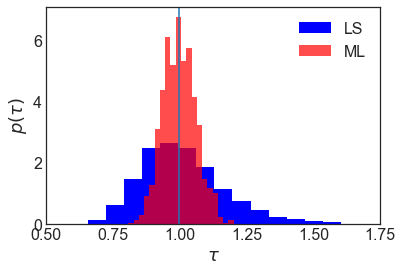

In [35]:
# decay time
plt.figure(facecolor="white")
plt.hist(result_array.T[0],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0.5,1.75))
plt.savefig("tau_50kdist300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [36]:
phi = 1/result_array.T[3]
theta = 1/result_array.T[1]
omega = 1/result_array.T[4]
dA = np.sqrt(-theta/(phi*theta-omega**2))
dT = np.sqrt(-phi/(phi*theta-omega**2))*delta_t


In [37]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS mean (real): 1.0141547074680768
Decay time LS std (real): 0.16322139079535763
Decay time LS stderr (real): 0.0007299482504009563
Decay time (mean-true)/stderr: 19.391384882834764
Decay time LS std (fit): 0.007206785195141684
Decay time LS std (fit corrected): 0.00716499851510287
Decay time Bayes mean (real): 0.9992300383205097
Decay time Bayes std (real): 0.061219567565266524
Decay time Bayes stderr (real): 0.0002737822292581545
Decay time Bayes std (fit): 0.06351449363327077


/Users/hstrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


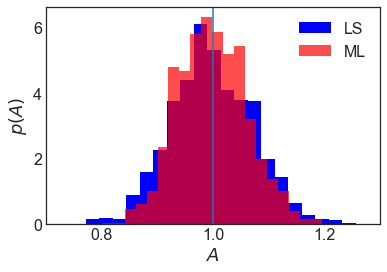

In [38]:
# amplitude
plt.hist(result_array.T[2],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_Bayes_array.T[0],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0.7,1.3))
plt.savefig("A_50kdist300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [39]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 0.998152590033822
Amplitude LS std (real): 0.07356114667854254
Amplitude LS stderr (real): 0.000328975448952108
Amplitude LS std (fit): 0.005036283918646518
Amplitude LS std (fit corrected): 0.005000106484221415
Amplitude Bayes mean (real): 0.9990024329675402
Amplitude Bayes std (real): 0.06098900903839772
Amplitude Bayes std (fit): 0.06318251995858944


(1000, 5)
(1000, 4)
(0.4123195278321039, 2.5291513124914114e-42)


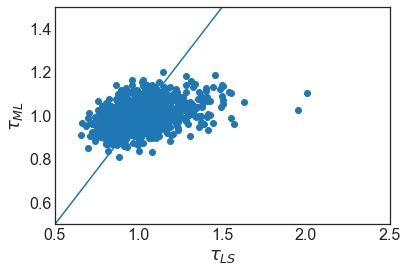

In [40]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(result_array.T[0],result_Bayes_array.T[2])
plt.plot([0.1,1.9],[0.1,1.9])
plt.xlim((0.5,2.5))
plt.ylim((0.5,1.5))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_50kcorr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.815686829361789, 1.8390086623559414e-239)


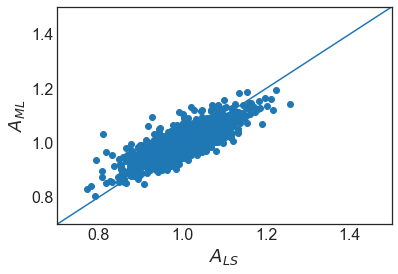

In [41]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0])
plt.plot([0,1.8],[0,1.8])
plt.xlim((0.7,1.5))
plt.ylim((0.7,1.5))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))
plt.savefig("A_50kcorr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [42]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],dA,result_array.T[0],dT):
    print(i,a,da,t,dt)

0 1.0452169576917796 0.008192693538894544 0.979347834695562 0.010924379068388102
1 1.011329871177037 0.0029333886747069005 1.0709302440238075 0.004423725481474864
2 1.0579760545286718 0.005051106912901595 1.1206409536565192 0.00762487618795323
3 0.9224148383070752 0.007170497172076655 0.9311946784848645 0.010299979458698939
4 0.9116949086699562 0.0018994599829523866 0.9042816096898878 0.0026806876567649243
5 0.9759232431763911 0.00414056290736221 0.9345343864506834 0.005641739283882326
6 0.7716728585393771 0.0028174231164398615 1.0770216023350347 0.005600501861681753
7 1.1316157144528458 0.006086886640024363 0.9974698907083861 0.007635853766078357
8 1.0821494957513744 0.003290834920820458 1.1313299489350237 0.004904182961869364
9 0.963808777185581 0.0018560651261032063 0.906138094089967 0.00248289668624473
10 0.9432441160932481 0.005051780177171397 1.2379039186361407 0.009474300606758423
11 1.1007883412966555 0.005813626661662575 0.926497771733887 0.0069622056491816155
12 0.93605064675

514 1.0750999170496942 0.004825955214826401 1.2858361897324253 0.00826075723816837
515 1.0851830353562444 0.005654006211673842 0.9738957156459234 0.007220873894224854
516 0.8522146493236449 0.0035194241847402033 1.1917503790304647 0.007024496360943171
517 1.0402208718706305 0.005091331278286434 1.121410749395818 0.00782294158962157
518 0.963509969300804 0.004101238404420248 0.8132064252887378 0.004926372449893956
519 1.0641180812629414 0.0023002625238803965 1.0815519102861055 0.0033301565605431556
520 1.0623228510347986 0.010397348947106816 0.8367615676550864 0.011653334366568948
521 0.9119494726881501 0.004720044677787653 1.0102577719038577 0.007442114332737079
522 0.9889072181155267 0.006271487552863589 0.8160332137896551 0.007365106341766505
523 0.847987366049048 0.006031681838299233 1.3588695131138309 0.013872997344110682
524 1.0398438517120026 0.009582294125844961 0.708043590066275 0.009291746893643437
525 0.9927670604690764 0.007770319951217414 0.8526194938096764 0.00949627571379

In [43]:
n=209
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))

0.00E+00
-2670014.205606128
0.3989422804014327
3.97E-01
-0.0020418367740739907


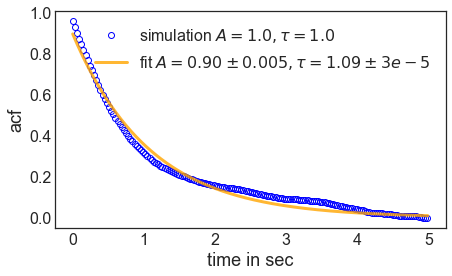

In [44]:
plt.figure(figsize=(7,4))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="blue",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,linewidth=3,color="orange",label=r"fit $A=0.90\pm0.005,\tau=1.09\pm3e-5$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_50kfit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [45]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']
